# 비교실험 : CutMix vs Mixup
|평가문항|상세기준|
|:---:|:---:|
|1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|
|2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함|
|3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|


# 0. 라이브러리 불러오기

In [1]:
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# 학습전에는 항상 GPU 환경 확인하기
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. Augmentation을 적용한 데이터셋 만들기 

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)


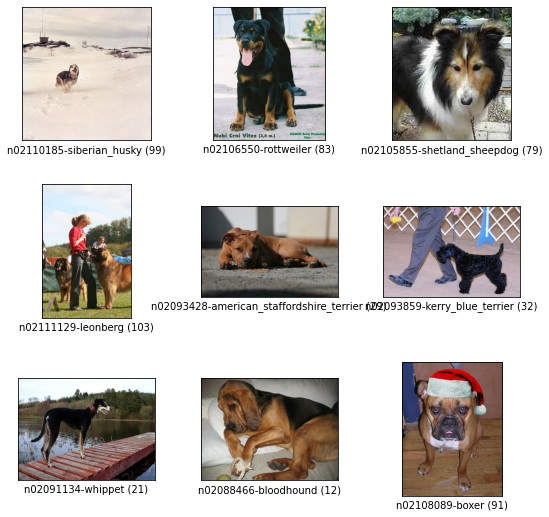

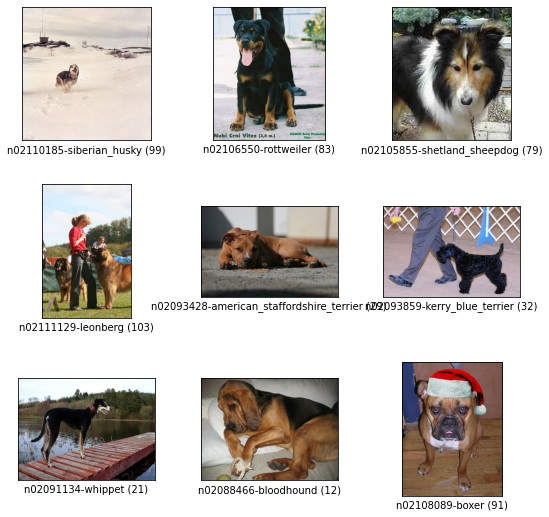

In [4]:
tfds.show_examples(ds_train,ds_info)

## 필요한 함수들 정의

In [5]:
num_classes = ds_info.features['label'].num_classes
num_classes

120

In [6]:
# 기본 전처리 함수
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224]) # (224, 224) 사이즈로 resize
    return tf.cast(image, tf.float32) / 255., label # 0~1 사이의 float32 Normalize

# aug 적용
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label


# 메인 전처리 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
    normalize_and_resize_img,
    num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
        augment,
        num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### CutMix

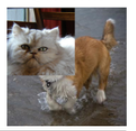
이미지 데이터를 자르고 섞는 방식이다.

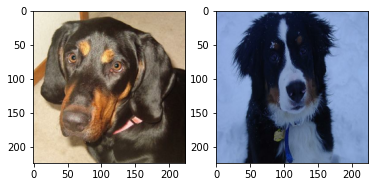

In [7]:
# 데이테섯에서 이미지 2개 가져오기
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [8]:
# 바탕에 삽입될 영역의 바운딩 박스의 위치를 경정하는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1] # 열
    image_size_y = image_a.shape[0] # 행
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min,y_min,x_max,y_max = get_clip_box(image_a,image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(124, shape=(), dtype=int32)
y :  tf.Tensor(143, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


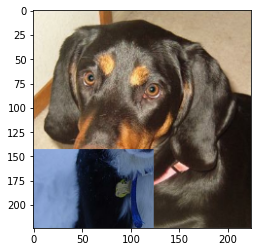

In [9]:
# 바탕이미지에서 바운딩 박스 바깥쪽 영역을, 
# 다른 이미지에서 바운딩 안쪽 영역을 가져와서합치는 함수
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [10]:
# 라벨섞어주는 함수
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.7998246 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [11]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup
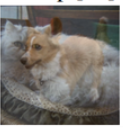
특정 비율로 픽셀별 값을 섞는 방식이다.


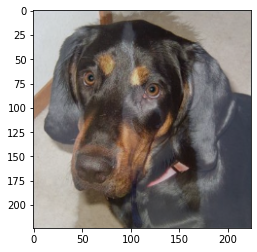

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.6949061  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.30509388 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [12]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [13]:
# 배치단위의 mixup() 함수
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [14]:
# 원핫인코딩
def onehot(image,label):
    label = tf.one_hot(label,num_classes)
    return image,label

### 메인 전처리 함수

In [15]:
# 메인 전처리 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [16]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

# 2. 모델 만들기

In [17]:
# Aug 미적용 ResNet50 모델
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [18]:
# Aug 적용 ResNet50 모델
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, #마지막 fully connected layer를 포함할지 여부
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [19]:
# CutMix용 ResNet50 모델
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, #마지막 fully connected layer를 포함할지 여부
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [20]:
# Mixup용 ResNet50 모델
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# 3. 모델 훈련하기

In [21]:
EPOCH=20
# aug 미적용
no_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = no_aug_resnet50.fit(
    ds_train_no_aug, # augmentation 미적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 200s 210ms/step - loss: 2.2071 - accuracy: 0.4448 - val_loss: 3.2443 - val_accuracy: 0.2304
Epoch 2/20
750/750 [==============================] - 156s 208ms/step - loss: 0.7743 - accuracy: 0.7829 - val_loss: 1.1124 - val_accuracy: 0.6775
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 0.3130 - accuracy: 0.9256 - val_loss: 0.9765 - val_accuracy: 0.7130
Epoch 4/20
750/750 [==============================] - 156s 207ms/step - loss: 0.0984 - accuracy: 0.9859 - val_loss: 0.9132 - val_accuracy: 0.7276
Epoch 5/20
750/750 [==============================] - 171s 227ms/step - loss: 0.0334 - accuracy: 0.9980 - val_loss: 0.9104 - val_accuracy: 0.7406
Epoch 6/20
750/750 [==============================] - 156s 208ms/step - loss: 0.0183 - accuracy: 0.9993 - val_loss: 0.9108 - val_accuracy: 0.7474
Epoch 7/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0124 - accuracy: 0.9996 - val_loss: 0.9161 -

In [22]:
# aug 적용
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 163s 208ms/step - loss: 2.3022 - accuracy: 0.4231 - val_loss: 2.8531 - val_accuracy: 0.2873
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 0.9482 - accuracy: 0.7274 - val_loss: 1.1428 - val_accuracy: 0.6672
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 0.5062 - accuracy: 0.8646 - val_loss: 1.2344 - val_accuracy: 0.6529
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 0.2585 - accuracy: 0.9383 - val_loss: 1.1220 - val_accuracy: 0.6839
Epoch 5/20
750/750 [==============================] - 155s 207ms/step - loss: 0.1443 - accuracy: 0.9732 - val_loss: 0.9356 - val_accuracy: 0.7316
Epoch 6/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0845 - accuracy: 0.9869 - val_loss: 0.9871 - val_accuracy: 0.7283
Epoch 7/20
750/750 [==============================] - 155s 207ms/step - loss: 0.0519 - accuracy: 0.9937 - val_loss: 0.9972 -

In [23]:
# cutmix적용
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 165s 210ms/step - loss: 3.8285 - accuracy: 0.2153 - val_loss: 3.7703 - val_accuracy: 0.1421
Epoch 2/20
750/750 [==============================] - 156s 208ms/step - loss: 2.9497 - accuracy: 0.4373 - val_loss: 1.3055 - val_accuracy: 0.6542
Epoch 3/20
750/750 [==============================] - 156s 209ms/step - loss: 2.6297 - accuracy: 0.5352 - val_loss: 1.2137 - val_accuracy: 0.6607
Epoch 4/20
750/750 [==============================] - 156s 209ms/step - loss: 2.4337 - accuracy: 0.5958 - val_loss: 1.2408 - val_accuracy: 0.6592
Epoch 5/20
750/750 [==============================] - 156s 208ms/step - loss: 2.2839 - accuracy: 0.6442 - val_loss: 1.2537 - val_accuracy: 0.6628
Epoch 6/20
750/750 [==============================] - 156s 209ms/step - loss: 2.1593 - accuracy: 0.6880 - val_loss: 1.2364 - val_accuracy: 0.6634
Epoch 7/20
750/750 [==============================] - 157s 209ms/step - loss: 2.0631 - accuracy: 0.7178 - val_loss: 1.1544 -

In [24]:
# mixup적용
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_mixup, # mixup적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 165s 210ms/step - loss: 3.6986 - accuracy: 0.2470 - val_loss: 4.4406 - val_accuracy: 0.0918
Epoch 2/20
750/750 [==============================] - 157s 209ms/step - loss: 2.8589 - accuracy: 0.4763 - val_loss: 1.4960 - val_accuracy: 0.5788
Epoch 3/20
750/750 [==============================] - 172s 229ms/step - loss: 2.5761 - accuracy: 0.5845 - val_loss: 1.2925 - val_accuracy: 0.6348
Epoch 4/20
750/750 [==============================] - 157s 209ms/step - loss: 2.3956 - accuracy: 0.6578 - val_loss: 1.3975 - val_accuracy: 0.6258
Epoch 5/20
750/750 [==============================] - 157s 209ms/step - loss: 2.2260 - accuracy: 0.7207 - val_loss: 1.4227 - val_accuracy: 0.6147
Epoch 6/20
750/750 [==============================] - 157s 209ms/step - loss: 2.1669 - accuracy: 0.7394 - val_loss: 1.3189 - val_accuracy: 0.6439
Epoch 7/20
750/750 [==============================] - 157s 209ms/step - loss: 2.0708 - accuracy: 0.7752 - val_loss: 1.2351 -

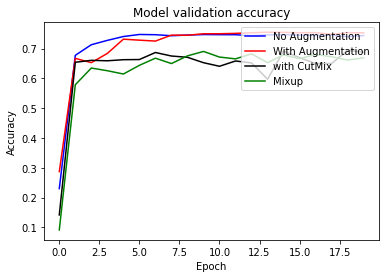

In [25]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'],'b')
plt.plot(history_resnet50_aug.history['val_accuracy'],'r')
plt.plot(history_resnet50_cutmix.history['val_accuracy'],'k')
plt.plot(history_resnet50_mixup.history['val_accuracy'],'g')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation','With Augmentation','with CutMix','Mixup'],loc='upper right')
plt.show()

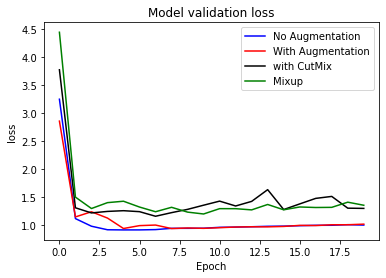

In [26]:
plt.plot(history_resnet50_no_aug.history['val_loss'],'b')
plt.plot(history_resnet50_aug.history['val_loss'],'r')
plt.plot(history_resnet50_cutmix.history['val_loss'],'k')
plt.plot(history_resnet50_mixup.history['val_loss'],'g')
plt.title('Model validation loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation','With Augmentation','with CutMix','Mixup'],loc='upper right')
plt.show()

# 회고
예상했던 것과 다른 결과가 나왔다. CutMix와 Mixup 기법을 쓰는 것이 더 성능이 좋을 것이라 예측했는데 no aug > aug > CutMix > Mixup 순으로 성능이 좋았다. 조원들도 이런 결과가 나온 것을 보아하니 내가 잘못한 건 아닌 것 같다. 왜 이런 결과가 나왔을까 생각을 해봤는데 이미 데이터양이 충분해서 그런 것 같다. 데이터의 품질도 양도 다 좋았는데 aug와 여러가지 기법을 써서 적용하니 품질이 떨어져 이런 결과가 나온 것으로 예측된다. 